In [1]:
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from torch.utils.data import Dataset, DataLoader
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split

/Users/shanoonissaka/Documents/school/thesis-project/code/audio-detect/audio-detect/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_audio_files(directory, sr=16000):
    audio_data = []
    labels = []
    class_labels = {label: i for i, label in enumerate(os.listdir(directory))}  # Assign numerical labels

    for label in os.listdir(directory):
        class_dir = os.path.join(directory, label)
        if os.path.isdir(class_dir):
            for file in os.listdir(class_dir):
                file_path = os.path.join(class_dir, file)
                try:
                    audio, _ = librosa.load(file_path, sr=sr)  # Load audio
                    audio_data.append(audio)
                    labels.append(class_labels[label])  # Convert label to integer
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")
    
    return np.array(audio_data, dtype=object), np.array(labels)

In [3]:
train_dir = "/Users/shanoonissaka/Documents/school/thesis-project/datasets/audio/training"
test_dir = "/Users/shanoonissaka/Documents/school/thesis-project/datasets/audio/testing"

In [4]:
train_features, train_labes = load_audio_files(train_dir)

In [5]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")

/Users/shanoonissaka/Documents/school/thesis-project/code/audio-detect/audio-detect/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/shanoonissaka/Documents/school/thesis-project/code/audio-detect/audio-detect/lib/python3.11/site-packages/transformers/configuration_utils.py:365: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
/Users/shanoonissaka/Documents/school/thesis-project/code/audio-detect/audio-detect/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be re

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmbedding(
  

In [7]:
def extract_wav2vec2_features(audio_data):
    features = []
    
    for audio in audio_data:
        inputs = processor(audio, sampling_rate=16000, return_tensors="pt", padding=True)
        inputs = {key: val.to(device) for key, val in inputs.items()}  # Move to GPU if available
        
        with torch.no_grad():
            outputs = model(**inputs)
        
        features.append(outputs.last_hidden_state.mean(dim=1).cpu().numpy())  # Take mean across time
        
    return np.array(features)

In [8]:
wav_vec_train_features = extract_wav2vec2_features(train_features)

In [9]:
class AudioDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(np.vstack(features), dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [10]:
train_dataset = AudioDataset(wav_vec_train_features, train_labes)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [11]:
# Extract features and labels from the DataLoader
def dataloader_to_numpy(dataloader):
    feature_list, label_list = [], []
    for batch in dataloader:
        inputs, labels = batch
        feature_list.append(inputs.cpu().numpy())  # Convert to NumPy
        label_list.append(labels.cpu().numpy())

    flat_features = np.vstack(feature_list)  # Stack into single NumPy array
    flat_labels = np.hstack(label_list)  # Stack labels

    return flat_features, flat_labels

In [12]:
flatten_features, flatten_labels = dataloader_to_numpy(train_loader)

In [13]:
# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(flatten_features, flatten_labels, test_size=0.2, random_state=42)


In [14]:
from sklearn.svm import SVC
svm_model = SVC(probability=True)

In [15]:
svm_model.fit(X_train, y_train)

SVC(probability=True)

In [16]:
from sklearn.metrics import accuracy_score, classification_report
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
svm_report = classification_report(y_test, y_pred)
print("Classification Report:\n", svm_report)

Accuracy: 0.98
Classification Report:
               precision    recall  f1-score   support

           1       0.99      0.96      0.98       199
           2       0.97      1.00      0.98       240

    accuracy                           0.98       439
   macro avg       0.98      0.98      0.98       439
weighted avg       0.98      0.98      0.98       439



In [17]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Accuracy: {accuracy_dt:.2f}")
dt_report = classification_report(y_test, y_pred_dt)
print("Classification Report:\n", dt_report)    

Decision Tree Accuracy: 0.93
Classification Report:
               precision    recall  f1-score   support

           1       0.90      0.94      0.92       199
           2       0.95      0.91      0.93       240

    accuracy                           0.93       439
   macro avg       0.93      0.93      0.93       439
weighted avg       0.93      0.93      0.93       439



In [18]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")
rf_report = classification_report(y_test, y_pred_rf)
print("Classification Report:\n", rf_report)

Random Forest Accuracy: 0.97
Classification Report:
               precision    recall  f1-score   support

           1       0.99      0.94      0.97       199
           2       0.95      1.00      0.97       240

    accuracy                           0.97       439
   macro avg       0.97      0.97      0.97       439
weighted avg       0.97      0.97      0.97       439



In [19]:
test_features, test_labels = load_audio_files(test_dir)
wav_vec_test_features = extract_wav2vec2_features(test_features)
test_dataset = AudioDataset(wav_vec_test_features, test_labels)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
flatten_test_features, flatten_test_labels = dataloader_to_numpy(test_loader)
test_predictions = rf_model.predict(flatten_test_features)
test_accuracy = accuracy_score(flatten_test_labels, test_predictions)
print(f"Test Accuracy: {test_accuracy:.2f}")
test_report = classification_report(flatten_test_labels, test_predictions)
print("Test Classification Report:\n", test_report)

Test Accuracy: 0.77
Test Classification Report:
               precision    recall  f1-score   support

           1       0.92      0.64      0.76       518
           2       0.67      0.93      0.78       406

    accuracy                           0.77       924
   macro avg       0.80      0.79      0.77       924
weighted avg       0.81      0.77      0.77       924



In [20]:
svm_test_predictions = svm_model.predict(flatten_test_features)
svm_test_accuracy = accuracy_score(flatten_test_labels, svm_test_predictions)
print(f"SVM Test Accuracy: {svm_test_accuracy:.2f}")
svm_test_report = classification_report(flatten_test_labels, svm_test_predictions)
print("SVM Test Classification Report:\n", svm_test_report)

SVM Test Accuracy: 0.90
SVM Test Classification Report:
               precision    recall  f1-score   support

           1       0.88      0.94      0.91       518
           2       0.92      0.84      0.88       406

    accuracy                           0.90       924
   macro avg       0.90      0.89      0.89       924
weighted avg       0.90      0.90      0.90       924



In [21]:
dt_test_predictions = dt_model.predict(flatten_test_features)
dt_test_accuracy = accuracy_score(flatten_test_labels, dt_test_predictions)
print(f"Decision Tree Test Accuracy: {dt_test_accuracy:.2f}")
dt_test_report = classification_report(flatten_test_labels, dt_test_predictions)
print("Decision Tree Test Classification Report:\n", dt_test_report)

Decision Tree Test Accuracy: 0.67
Decision Tree Test Classification Report:
               precision    recall  f1-score   support

           1       0.83      0.53      0.64       518
           2       0.59      0.86      0.70       406

    accuracy                           0.67       924
   macro avg       0.71      0.69      0.67       924
weighted avg       0.72      0.67      0.67       924



In [31]:
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay

In [32]:
svm_cm = confusion_matrix(flatten_test_labels, svm_test_predictions, labels=np.unique(flatten_test_labels))
print("SVM Confusion Matrix:\n", svm_cm)

dt_cm = confusion_matrix(flatten_test_labels, dt_test_predictions, labels=np.unique(flatten_test_labels))
print("Decision Tree Confusion Matrix:\n", dt_cm)
rf_cm = confusion_matrix(flatten_test_labels, test_predictions, labels=np.unique(flatten_test_labels))
print("Random Forest Confusion Matrix:\n", rf_cm)

SVM Confusion Matrix:
 [[489  29]
 [ 66 340]]
Decision Tree Confusion Matrix:
 [[273 245]
 [ 57 349]]
Random Forest Confusion Matrix:
 [[331 187]
 [ 27 379]]


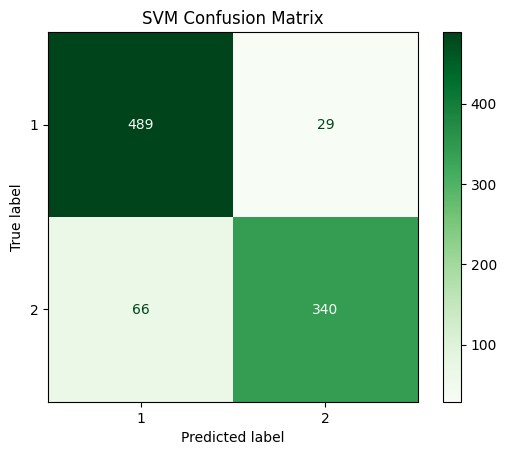

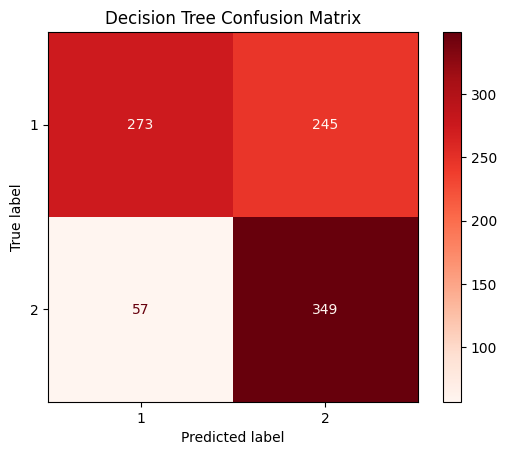

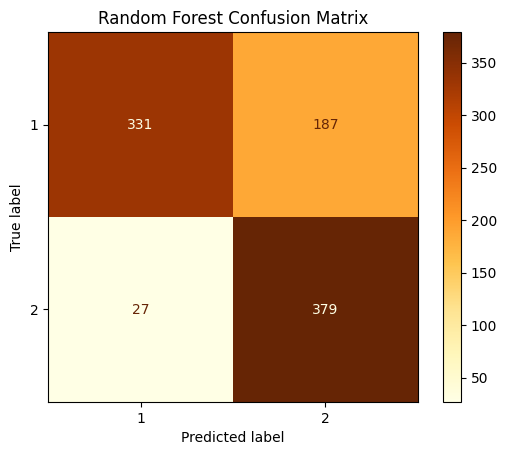

In [42]:
import matplotlib.pyplot as plt
svm_cm_display = ConfusionMatrixDisplay(confusion_matrix=svm_cm, display_labels=np.unique(flatten_test_labels))
svm_cm_display.plot(cmap='Greens')
plt.title('SVM Confusion Matrix')
plt.savefig('svm_confusion_matrix.png')
plt.show()

dt_cm_display = ConfusionMatrixDisplay(confusion_matrix=dt_cm, display_labels=np.unique(flatten_test_labels))
dt_cm_display.plot(cmap='Reds')
plt.title('Decision Tree Confusion Matrix')
plt.savefig('dt_confusion_matrix.png')
plt.show()

rf_cm_display = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=np.unique(flatten_test_labels))
rf_cm_display.plot(cmap='YlOrBr')
plt.title('Random Forest Confusion Matrix')
plt.savefig(f'rf_confusion_matrix.png')
plt.show()

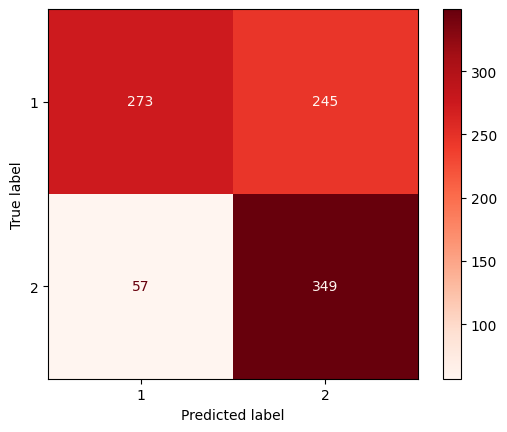

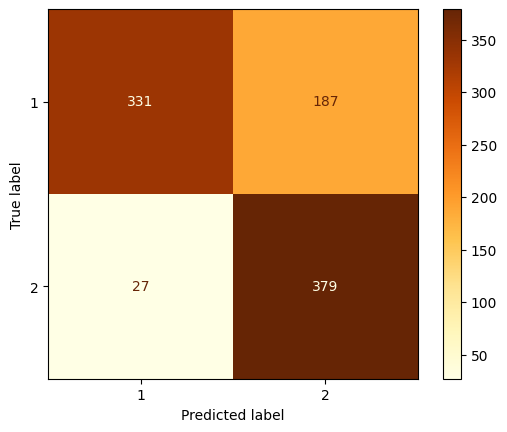

In [ ]:

dt_cm_display = ConfusionMatrixDisplay(confusion_matrix=dt_cm, display_labels=np.unique(flatten_test_labels))
dt_cm_display.plot(cmap='Reds')


rf_cm_display = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=np.unique(flatten_test_labels))
rf_cm_display.plot(cmap='YlOrBr')



In [43]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [44]:
def create_cnn_model(input_shape, num_classes):
    print(f"input shape : {input_shape}")
    print(f"number of classes : {num_classes}")
    model = Sequential([
        Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def train_cnn_model(X_train, y_train, X_val, y_val, input_shape, num_classes, save_path):
    model = create_cnn_model(input_shape, num_classes)
    
    checkpoint = ModelCheckpoint(save_path, monitor='val_loss', save_best_only=True)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=16,
        callbacks=[early_stop, checkpoint],
        verbose=1
    )
    model.summary()
    return model, history

In [50]:

input_shape = (24, 32, 1)
num_classes = len(np.unique(y_test))  # Number of unique classes in test labels
model = create_cnn_model(input_shape, num_classes)
model.summary()

input shape : (24, 32, 1)
number of classes : 2
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 22, 30, 16)        160       
                                                                 
 batch_normalization_12 (Ba  (None, 22, 30, 16)        64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 11, 15, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 9, 13, 32)         4640      
                                                                 
 batch_normalization_13 (Ba  (None, 9, 13, 32)         128       
 tchNormalization)                                               
      

In [ ]:
# Reshape features for CNN input
X_train_cnn = X_train.reshape(-1, 24, 32, 1)
X_test_cnn = X_test.reshape(-1, 24, 32, 1)

cnn_model, cnn_history = train_cnn_model(
    X_train_cnn, y_train, X_test_cnn, y_test,
    input_shape,
    len(np.unique(y_train)),  # ✅ matches training labels
    ""
)

input shape : (24, 32, 1)
number of classes : 2
Epoch 1/50


2025-06-28 18:52:03.423846: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at sparse_xent_op.cc:103 : INVALID_ARGUMENT: Received a label value of 2 which is outside the valid range of [0, 2).  Label values: 1 1 2 2 2 2 2 1 2 2 2 2 1 1 2 1


InvalidArgumentError: Graph execution error:

Detected at node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/shanoonissaka/Documents/school/thesis-project/code/audio-detect/audio-detect/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/shanoonissaka/Documents/school/thesis-project/code/audio-detect/audio-detect/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/shanoonissaka/Documents/school/thesis-project/code/audio-detect/audio-detect/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/shanoonissaka/Documents/school/thesis-project/code/audio-detect/audio-detect/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/Users/shanoonissaka/Documents/school/thesis-project/code/audio-detect/audio-detect/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/Users/shanoonissaka/Documents/school/thesis-project/code/audio-detect/audio-detect/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/Users/shanoonissaka/Documents/school/thesis-project/code/audio-detect/audio-detect/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/Users/shanoonissaka/Documents/school/thesis-project/code/audio-detect/audio-detect/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/Users/shanoonissaka/Documents/school/thesis-project/code/audio-detect/audio-detect/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/Users/shanoonissaka/Documents/school/thesis-project/code/audio-detect/audio-detect/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/Users/shanoonissaka/Documents/school/thesis-project/code/audio-detect/audio-detect/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/shanoonissaka/Documents/school/thesis-project/code/audio-detect/audio-detect/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3098, in run_cell

  File "/Users/shanoonissaka/Documents/school/thesis-project/code/audio-detect/audio-detect/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3153, in _run_cell

  File "/Users/shanoonissaka/Documents/school/thesis-project/code/audio-detect/audio-detect/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/Users/shanoonissaka/Documents/school/thesis-project/code/audio-detect/audio-detect/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3362, in run_cell_async

  File "/Users/shanoonissaka/Documents/school/thesis-project/code/audio-detect/audio-detect/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3607, in run_ast_nodes

  File "/Users/shanoonissaka/Documents/school/thesis-project/code/audio-detect/audio-detect/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3667, in run_code

  File "/var/folders/nq/4x8wzch51s73gjb0by0md3q40000gn/T/ipykernel_1600/2547924767.py", line 6, in <module>

  File "/var/folders/nq/4x8wzch51s73gjb0by0md3q40000gn/T/ipykernel_1600/2461286527.py", line 28, in train_cnn_model

  File "/Users/shanoonissaka/Documents/school/thesis-project/code/audio-detect/audio-detect/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/shanoonissaka/Documents/school/thesis-project/code/audio-detect/audio-detect/lib/python3.11/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/Users/shanoonissaka/Documents/school/thesis-project/code/audio-detect/audio-detect/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/Users/shanoonissaka/Documents/school/thesis-project/code/audio-detect/audio-detect/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/Users/shanoonissaka/Documents/school/thesis-project/code/audio-detect/audio-detect/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/Users/shanoonissaka/Documents/school/thesis-project/code/audio-detect/audio-detect/lib/python3.11/site-packages/keras/src/engine/training.py", line 1151, in train_step

  File "/Users/shanoonissaka/Documents/school/thesis-project/code/audio-detect/audio-detect/lib/python3.11/site-packages/keras/src/engine/training.py", line 1209, in compute_loss

  File "/Users/shanoonissaka/Documents/school/thesis-project/code/audio-detect/audio-detect/lib/python3.11/site-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/Users/shanoonissaka/Documents/school/thesis-project/code/audio-detect/audio-detect/lib/python3.11/site-packages/keras/src/losses.py", line 143, in __call__

  File "/Users/shanoonissaka/Documents/school/thesis-project/code/audio-detect/audio-detect/lib/python3.11/site-packages/keras/src/losses.py", line 270, in call

  File "/Users/shanoonissaka/Documents/school/thesis-project/code/audio-detect/audio-detect/lib/python3.11/site-packages/keras/src/losses.py", line 2454, in sparse_categorical_crossentropy

  File "/Users/shanoonissaka/Documents/school/thesis-project/code/audio-detect/audio-detect/lib/python3.11/site-packages/keras/src/backend.py", line 5775, in sparse_categorical_crossentropy

Received a label value of 2 which is outside the valid range of [0, 2).  Label values: 1 1 2 2 2 2 2 1 2 2 2 2 1 1 2 1
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_3298]

In [49]:
print(np.unique(y_train))  # Should be [0, 1, 2]
print(len(np.unique(y_train)))  # Should be 3

[1 2]
2
